In [1]:
from ast import literal_eval
from datetime import datetime, timedelta
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import plotly.offline as pof
import re
import requests
from zipfile import ZipFile
import plotly.io as pio

Набор данных для анализа доступен на: https://www.kaggle.com/datasets/patrickgendotti/mtg-all-cards

 
Перед вами набор данных, который содержит все когда-либо выпущенные карты Magic: The Gathering. Для большего понимания, о чем идет речь, вы можете перейти на официальный сайт игры и ознакомиться с базовыми правилами.

 
На основе этих данных составьте отчет, который будет содержать следующую информацию:

 
1) Распределение карт по цвету в зависимости от редкости.

2) Процент карт, запрещенных в формате Commander, а также распределение по типу для этих карт.

3) Топ-10 карт, не являющихся землями, которые были напечатаны в наибольшем количестве сетов.

4) Для карт, не являющихся землями, определите, какая часть из них даёт ману с помощью своего эффекта. Покажите распределение по типу маны, который дают эти карты. 

In [2]:
# для отображения нескольких вычисленных значений в ячейке
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

In [3]:
# Скачиваем файл с https://www.kaggle.com/datasets/patrickgendotti/mtg-all-cards

In [4]:
# Извлекаем dataframe
ZIP_FILE = 'archive.zip'
df = pd.read_csv(ZIP_FILE, compression='zip', low_memory=False)

In [5]:
# задаем количество отображаемых столбцов
pd.set_option('display.max_columns', 39)

In [6]:
df.head()

,name,multiverse_id,layout,names,mana_cost,cmc,colors,color_identity,type,supertypes,subtypes,rarity,text,flavor,artist,number,power,toughness,loyalty,variations,watermark,border,timeshifted,hand,life,reserved,release_date,starter,rulings,foreign_names,printings,original_text,original_type,legalities,source,image_url,set,set_name,id
0,Ancestor's Chosen,130550.0,normal,NaN,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,"['Human', 'Cleric']",Uncommon,First strike (This creature deals combat damag...,NaN,Pete Venters,1,4,4,NaN,['b7c19924-b4bf-56fc-aa73-f586e940bd42'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'name': 'Ausgewählter der Ahnfrau', 'text': ...","['10E', 'JUD', 'UMA']",First strike (This creature deals combat damag...,Creature - Human Cleric,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c
1,Ancestor's Chosen,NaN,normal,NaN,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,NaN,"['Human', 'Cleric']",Uncommon,First strike (This creature deals combat damag...,"""The will of all, by my hand done.""",Pete Venters,1★,4,4,NaN,['5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['10E', 'JUD', 'UMA']",NaN,NaN,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,NaN,10E,Tenth Edition,b7c19924-b4bf-56fc-aa73-f586e940bd42
2,Angel of Mercy,129465.0,normal,NaN,{4}{W},5.0,['White'],['W'],Creature — Angel,NaN,['Angel'],Uncommon,Flying\nWhen Angel of Mercy enters the battlef...,Every tear shed is a drop of immortality.,Volkan Baǵa,2,3,3,NaN,['8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'name': 'Engel der Gnade', 'text': 'Fliegend...","['10E', '8ED', '9ED', 'DDC', 'DVD', 'IMA', 'IN...",Flying (This creature can't be blocked except ...,Creature - Angel,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c
3,Angel of Mercy,NaN,normal,NaN,{4}{W},5.0,['White'],['W'],Creature — Angel,NaN,['Angel'],Uncommon,Flying\nWhen Angel of Mercy enters the battlef...,Every tear shed is a drop of immortality.,Volkan Baǵa,2★,3,3,NaN,['57aaebc1-850c-503d-9f6e-bb8d00d8bf7c'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['10E', '8ED', '9ED', 'DDC', 'DVD', 'IMA', 'IN...",NaN,NaN,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,NaN,10E,Tenth Edition,8fd4e2eb-3eb4-50ea-856b-ef638fa47f8a
4,Angelic Blessing,129711.0,normal,NaN,{2}{W},3.0,['White'],['W'],Sorcery,NaN,NaN,Common,Target creature gets +3/+3 and gains flying un...,Only the warrior who can admit mortal weakness...,Mark Zug,3,NaN,NaN,NaN,['c5655330-5131-5f40-9d3e-0549d88c6e9e'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[{'name': 'Himmlischer Segen', 'text': 'Eine K...","['10E', '9ED', 'EXO', 'P02', 'POR', 'PS11', 'S...",Target creature gets +3/+3 and gains flying un...,Sorcery,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,55bd38ca-dc73-5c06-8f80-a6ddd2f44382


### 1) Распределение карт по цвету в зависимости от редкости.

In [7]:
# получаем датафрейм без дубликатов(рассматриваем уникальные редкость и цвет с именем в строках)
clear_df =  df.drop_duplicates(subset=['name'])

In [8]:
# Проверим количество пустых значений по колонкам colors color_identity
df[['name', 'colors', 'color_identity', 'rarity']].isna().sum()

name                  0
colors            14158
color_identity     7031
rarity                0
dtype: int64

In [9]:
# Есть ли строки, где одно из полей colors color_identity заполнено
df.query('color_identity.isna() == True and colors.isna() == True', engine='python').shape[0]
df.query('color_identity.isna() == True and colors.isna() == False', engine='python').shape[0]
df.query('color_identity.isna() == False and colors.isna() == True', engine='python').shape[0]

7031

0

7127

Получили, что строк с пустым значением color_identity и заполненым colors нет, берем столбец color_identity в качестве анализируемого

In [10]:
# приводим данные в колонке color_identity к формату массива для разбиения, фильтруя NA данные
colors_df = clear_df[['name', 'color_identity', 'rarity']]
colors_df.color_identity = colors_df.query('color_identity.isna() == False', engine='python').color_identity.apply(literal_eval)

C:\Users\DimDolino\AppData\Local\Temp\ipykernel_20244\3085196938.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
# Разбиваем колонку colors на индивидуальные цвета
single_color = colors_df.explode('color_identity')

In [12]:
# сбрасываем индекс
single_color.reset_index(drop=True, inplace=True)

In [13]:
# Заменяем значения с отсутсвием данных строкой No_color
single_color.color_identity = single_color.color_identity.fillna('No_color')

In [14]:
# преобразуем сокращения в цвета
single_color.color_identity = single_color.color_identity.map({'W': 'White', 'U': 'Blue', 'B': 'Black', 'R': 'Red', 'G': 'Green'})

In [15]:
# Формируем датафрейм с распределением карт по цвету в зависимости от редкости
color_rarity_df = single_color.groupby(['rarity', 'color_identity'], as_index=False).agg({'name': 'count'}).rename(columns={'name': 'number_of_cards'})

In [16]:
 # Заменяем значения с отсутсвием данных строкой No_color
single_color.color_identity = single_color.color_identity.fillna('No_color')

In [17]:
# Переименуем колонку color_identity в colors
single_color = single_color.rename(columns={'color_identity': 'colors'})

In [18]:
 # Формируем датафрейм с распределением карт по цвету в зависимости от редкости
color_rarity_df = single_color.groupby(['rarity', 'colors'], as_index=False).agg({'name': 'count'}).rename(columns={'name': 'number_of_cards'})

Ниже представлена функция, в которой собраны предыдущие шаги

In [19]:
# функция для преобразования датафрейма к виду, необходимому для построения графика(добавил дополнительно), без него также все работает
def find_color_rarity_df(ZIP_FILE):
    """Forming dataframe from zip arhive with columns:
    rarity, color, number_of_cards
    """
    df = pd.read_csv(ZIP_FILE, compression='zip', low_memory=False)
    clear_df = df.drop_duplicates(subset=['name', 'color_identity', 'rarity'])[['name', 'color_identity', 'rarity']]
    # приводим данные в колонке colors к формату массива для разбиения, убирая NA данные
    clear_df.color_identity = clear_df.query('color_identity.isna() == False', engine='python').color_identity.apply(literal_eval)
    # Разбиваем колонку colors на индивидуальные цвета
    single_color = clear_df.explode('color_identity')
    # сбрасываем индекс
    single_color.reset_index(drop=True, inplace=True)
    # преобразуем сокращения в цвета
    single_color.color_identity = single_color.color_identity.map({'W': 'White', 'U': 'Blue', 'B': 'Black', 'R': 'Red', 'G': 'Green'})
    # Заменяем значения с отсутсвием данных строкой No_color
    single_color.color_identity = single_color.color_identity.fillna('No_color')
    # Переименуем колонку color_identity в colors
    single_color = single_color.rename(columns={'color_identity': 'colors'})
    # Формируем датафрейм с распределением карт по цвету в зависимости от редкости
    df_color = single_color.groupby(['rarity', 'colors'], as_index=False).agg({'name': 'count'}).rename(columns={'name': 'number_of_cards'}).sort_values('rarity')
    return df_color

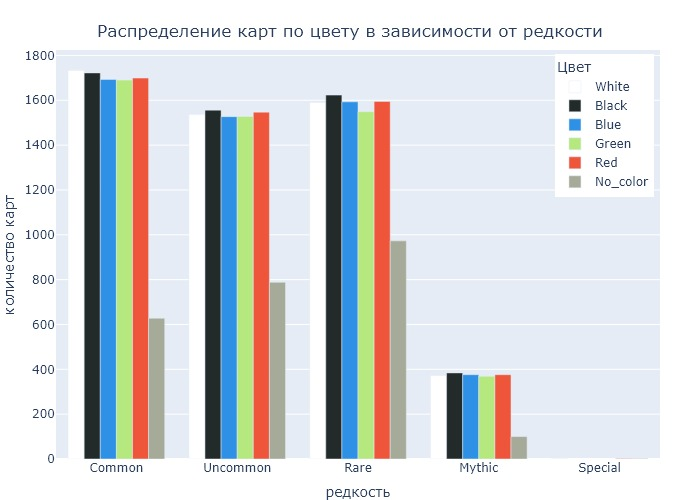

In [43]:
# Строим график 
fig = px.bar(color_rarity_df, x='rarity', y='number_of_cards', barmode='group', color='colors',
                  color_discrete_map={
                 'White': 'white',
                 'Black': '#222A2A',
                 'Blue': '#2E91E5',
                 'Green': '#B6E880',
                 'Red': '#EF553B',
                 'No_color': 'rgb(165, 170, 153)'
                  },
                  category_orders={'rarity': ['Common', 'Uncommon', 'Rare', 'Mythic','Special', 'Bonus'],
                                   'colors': ['White', 'Black', 'Blue', 'Green', 'Red', 'No_color']})
# Кастомизация  графика в plotly
fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.99,
                            xanchor="right",
                            x=0.99
                            ),
                    title={
                            'text': "Распределение карт по цвету в зависимости от редкости",
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                  xaxis_title="редкость",
                  yaxis_title="количество карт",
                  legend_title="Цвет",
                  margin=dict(l=0, r=40, t=50, b=0))
fig.show(renderer='jpeg')

## 2) Процент карт, запрещенных в формате Commander, а также распределение по типу для этих карт.

In [21]:
# создаем датафрейм из трех колонок:
Commander_df = clear_df[['name', 'legalities', 'rarity']]

In [22]:
# В колонке legalities, необходимой для анализа, есть пустые строки, учтем это при фильтрации
Commander_df.legalities.isna().sum()

970

In [23]:
# напишем функцию для поиска запрещенных карт, если в колонке legalities
def find_illegal(string):
    """функция поиска запрещенных карт:
    если в поле имеется значение 
    format': 'Commander', 'legality': 'Legal,
    значит карта используется в формате и нам не нужна,
    возвращается False, иначе True.
    Если в строке пустое значение, то считаем карту разрешенной
    (без запретов)
    """
    try:
        if f"'format': 'Commander', 'legality': 'Legal'" in string:
            return False
        else:
            return True
    except:
        return False

In [24]:
# функция для вывода процента запрещенных карт формата commander и распределение по редкости (шаги объединил в функцию)
def Commander_illegal(df):
    Commander_df = df.drop_duplicates(subset=['name', 'rarity'])[['name', 'legalities', 'rarity']]
    # Получаем датафрейм запрещенных карт
    Illegal_df = Commander_df.loc[Commander_df.legalities.apply(find_illegal)]

    # группируем по редкости и определяем количество
    Illegal_cards = Illegal_df.groupby('rarity', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'illegal_in_Commander'})
    # тоже самое для всех карт, не только запрещенных
    all_cards = Commander_df.groupby('rarity', as_index=False).agg({'name': 'count'}).rename(columns={'name': 'all_cards'})
    # объединяем датафреймы по полю rarity
    Illegal_cards = Illegal_cards.merge(all_cards, on='rarity', how='outer')

    # Проверям, что не потеряли строки при преобразовании
    Illegal_cards.all_cards.sum() == Commander_df.shape[0]

    # расчитаем процент запрещенных карт относительно карт в данной группе и общего числа
    Illegal_cards['percentage'] = round((Illegal_cards.illegal_in_Commander / Illegal_cards.all_cards)*100, 2) # процент карт отосительно карт в редкости
    Illegal_cards['abs_percentage'] = round((Illegal_cards.illegal_in_Commander / Illegal_cards.all_cards.sum())*100, 3) # процент относительно всех

    # процент запрещенных карт 
    percent = round(Illegal_df.shape[0] / Commander_df.shape[0] *100, 3)
    
    print(f"Процент карт, запрещенных в формате Commander {percent}%")
    print(f"Распределение запрещенных карт по редкости:\n"
          f"{Illegal_cards}")

In [25]:
Commander_illegal(df)

Процент карт, запрещенных в формате Commander 1.228%
Распределение запрещенных карт по редкости:
     rarity  illegal_in_Commander  all_cards  percentage  abs_percentage
0     Bonus                     8         10       80.00           0.030
1    Common                    48       8873        0.54           0.180
2    Mythic                    59       1583        3.73           0.222
3      Rare                   142       8037        1.77           0.533
4   Special                     2        243        0.82           0.008
5  Uncommon                    68       7885        0.86           0.255


## 3) Топ-10 карт, не являющихся землями, которые были напечатаны в наибольшем количестве сетов.

In [26]:
# Для определения типа карты используем колонку type, в которй ищем упоминания о Land
def find_Land(string):
    """функция поиска типа "земли":
    если в поле содержится 'Land',
    значит карта является землей -> False
    """
    if "Land" in string:
        return False
    else:
        return True

In [27]:
# Применяем фильтрацию с помощью loc и получеаем топ-10 карт (Не земель)
df.loc[df.type.apply(find_Land)].groupby('name', as_index=False) \
                                .agg({'set_name': 'nunique'}) \
                                .rename(columns={'set_name': 'number_of_sets'}) \
                                .sort_values('number_of_sets', ascending=False) \
                                .reset_index(drop=True).head(10)

,name,number_of_sets
0,Giant Growth,47
1,Counterspell,46
2,Serra Angel,42
3,Swords to Plowshares,42
4,Dark Ritual,41
5,Disenchant,41
6,Sol Ring,41
7,Llanowar Elves,40
8,Fireball,35
9,Air Elemental,33


## 4) Для карт, не являющихся землями, определите, какая часть из них даёт ману с помощью своего эффекта. Покажите распределение по типу маны, который дают эти карты. 

In [28]:
# Напишем функцию для поиска карт, дающих баффы или прибавку к мане
def find_buff(string):
    """функция поиска маны в упоминании карты:
    если в поле содержится 'Add',
    значит карта дает ману -> True
    """
    try:
        if "Add" in string:
            return True
        else:
            return False  
    except:
        return False

In [29]:
# формируем датафрейм с описанием карт, где имеется информация о необходимых бафах и применяем 
mana_df = df.drop_duplicates(subset=['name', 'rarity']).loc[df.type.apply(find_Land)].loc[df.text.apply(find_buff)][['name', 'text']]

In [30]:
# Создаем паттерн для поиска в текстовом описании карты меток цвета или добавления mana of any color
pattern = re.compile('mana|{[BUGRWC]}')

In [31]:
# Напишем функцию для создания нового столбца по данным в строке:
def find_all_colors(string):
    """ string -> all patterns from string or []
        function for searching pattern in string
        if some exceptions return same string type
        and format (for ignoring NaN values)"""
    try:
        mana = pattern.findall(string)
        if mana == []:
            return np.nan
        return mana
    except:
        return string

In [32]:
# Применяем функцию поиска вхождений и создаем датафрейм массивов
mana_df['mana_colors'] = mana_df.text.apply(find_all_colors)

In [33]:
# убираем строки, в которых были карты с бафами, дающими статы, а не ману
mana_df.dropna(subset=['mana_colors'], inplace=True)

In [34]:
# Считаем часть карт, дающих ману, от всего количества карт
giving_mana = mana_df.shape[0]

all_cards = df.drop_duplicates(subset=['name', 'rarity']).shape[0]

part_of_all_cards = round(giving_mana / all_cards, 3)

print(f"Часть карт, дающих ману: {part_of_all_cards}")

Часть карт, дающих ману: 0.033


In [35]:
# разбиваем массивы в колонке на строки
mana_type = mana_df.explode('mana_colors')

In [36]:
# В получившейся колонке 7 возможных значений, приведем их к читаемому виду
mana_type.mana_colors.value_counts(dropna=False)

mana    479
{G}     274
{C}     244
{R}     237
{B}     197
{U}     127
{W}     104
Name: mana_colors, dtype: int64

In [37]:
# маркеры в кавычках, которые отвечают за иконки на карте с принадлежностью к цвету,
# заменим на соответствующие цвета(и No_color для бесцветной фракции), mana-ключевое слово карт, дающих ману всех цветов
mana_type.mana_colors = mana_type.mana_colors \
                                 .map({'{G}': 'Green', '{B}': 'Black',
                                       '{U}': 'Blue','{W}': 'White', 
                                       '{R}': 'Red', '{C}': 'No_color', 
                                       'mana': 'Any_color'})

In [38]:
# Группируем карты по типу маны, которую они дают
giving_mana_type = mana_type.groupby('mana_colors', as_index=False).agg({"name": 'count'}).rename(columns={'name': 'number_of_cards'})

In [39]:
giving_mana_type

,mana_colors,number_of_cards
0,Any_color,479
1,Black,197
2,Blue,127
3,Green,274
4,No_color,244
5,Red,237
6,White,104


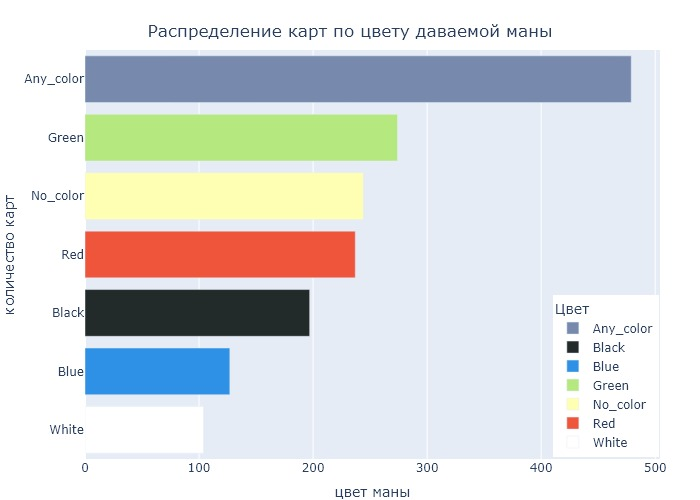

In [42]:
# строим график, отражающий число карт в каждой группе
fig = px.bar(giving_mana_type, x='number_of_cards', y='mana_colors', orientation='h', color='mana_colors', 
             color_discrete_map={
                 'White': 'white',
                 'Black': '#222A2A',
                 'Blue': '#2E91E5',
                 'Green': '#B6E880',
                 'Red': '#EF553B',
                 'No_color': 'rgb(255,255,179)',
                 'Any_color': '#778AAE'
                  })
# Кастомизация  графика в plotl
fig.update_layout(legend=dict(
                            yanchor="top",
                            y=0.4,
                            xanchor="right",
                            x=0.998
                            ),
                    title={
                            'text': "Распределение карт по цвету даваемой маны",
                            'y':0.95,
                            'x':0.5,
                            'xanchor': 'center',
                            'yanchor': 'top'
                            },
                  xaxis_title="цвет маны",
                  yaxis={'categoryorder':'total ascending'},
                  yaxis_title="количество карт", 
                  legend_title="Цвет",
                  margin=dict(l=0, r=40, t=50, b=0))
fig.show(renderer='jpeg')